# Read mnist, try basic operations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Reference and inspiration: https://keras.io/examples/mnist_cnn/

In [2]:
class Const:
    """All constants collected together."""
    nrows = 28
    nclasses = 10
    
C = Const()

In [3]:
(xtrain,ytrain), (xtest,ytest) = tf.keras.datasets.mnist.load_data()

def scale_mnist(x):
    x  = x.astype('float32')/255
    x = np.expand_dims(x,3) # Weird extra axis for channels, to make keras work
    return x
    
xtrain = scale_mnist(xtrain)
xtest  = scale_mnist(xtest)

ytrain = tf.keras.utils.to_categorical(ytrain, C.nclasses)
ytest  = tf.keras.utils.to_categorical(ytest, C.nclasses)

In [4]:
print(np.max(xtrain[1,:,:,0]) )
print(xtrain.shape)

1.0
(60000, 28, 28, 1)


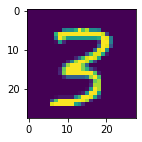

In [112]:
plt.figure(figsize=(2,2))
plt.imshow(xtrain[np.random.randint(xtrain.shape[0]),:,:,0]);

**Model choice**

The mostel is roughly based on these experiments (that show that this design is close to optimal):
* https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

I also assume that convolutional layers shouldn't be regularized:
* https://www.kaggle.com/c/state-farm-distracted-driver-detection/discussion/20201

And there's no use in L2 on the dense layer if we are doing dropout.

In [128]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(C.nrows,C.nrows,1)), # Universal input layer
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(C.nclasses, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam()

    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 64)              


 .235 .070 .051 .042 .035 .031 .028 .023 .021 .021
 .018 .017 .015 .014 .014 .014 .012 .011 .011 .012
 .009 .009 .010 .009 .009 .008 .008 .009 .008 .008

Text(0, 0.5, 'Loss')

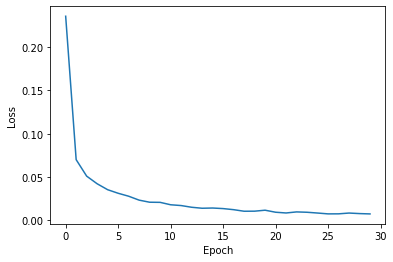

In [129]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print(f" {logs['loss']:.3f}".replace('0.','.'), end='')
        # Funny replace function strips leading zeros (looks better that way)
        

hist = model.fit(xtrain, ytrain,
                  batch_size=128,
                  epochs=30,
                  verbose=0,
                  validation_data=(xtest, ytest),
                  callbacks=[PrintDot()])

plt.plot(hist.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [130]:
score = model.evaluate(xtest, ytest, verbose=0)
print("Test loss:",score[0])
print('Accuracy:', score[1])
print('Percent error:', f'{(1-score[1])*100:0.2f}%')

Test loss: 0.022044461708074677
Accuracy: 0.9942
Percent error: 0.58%


# Results:

All models are tested on the same split of testing and training data, with **20 epochs** (conceivably, we could go to something like 50 epochs, as the loss was still decreasing a bit). Batch size = 128, Adadelta learning rate = 1.

Because in the long-term I want to pre-train the encoder, but reuse the decoder, it may make sense to keep the convolutional part heavier, and only run one Dense layer at the end. Not sure though. Maybe not. 

* Softmax(784→10). 7,850 params: 0.9274 accuracy
* Conv2d(32,(3,3))→Softmax(21632→10). 216,650 params: 0.9824
* Conv2d(32,(3,3))→Maxpool(2,2)→Softmax(5408→10). 54,410 params: 0.9838
* Conv2d(32,(3,3))→Maxpool(2,2)→Dropout(0.5)→Softmax(5408→10). 54,410 params: 0.9837. No improvement.
* Conv2d(32,(3,3))→Conv2d(64,(3,3))→Maxpool(2,2)→Dropout(0.5)→Softmax(5408→10). 110,986 params: 0.9899
* Conv2d(32,(5,5))→Conv2d(64,(5,5))→Maxpool(2,2)→Dropout(0.5)→Softmax(→10). 116,106 params: 0.9930
* Conv2d(32,(3,3))→Maxpool(2,2)→Conv2d(64,(3,3))→Maxpool(2,2)→Dropout(0.5)→Softmax(1600→10). 34,826 params: 0.9907
* Conv2d(32,(5,5))→Maxpool(2,2)→Conv2d(64,(5,5))→Maxpool(2,2)→Dropout(0.5)→Softmax(1024→10). 62,346 params: 0.9936
* Conv2d(32,(5,5))→Maxpool(2,2)→Conv2d(64,(5,5))→Maxpool(2,2)→Dropout(0.5)→Dense(64)→Dropout(0.5)→Softmax(10). 118,346 params: 0.9939
* Conv2d(32,(5,5))→Maxpool(2,2)→Conv2d(64,(5,5))→Maxpool(2,2)→Dropout(0.5)→Dense(128)→Dropout(0.5)→Softmax(10). 184,586 params: 0.9937
* Conv2d(32,(5,5))→Maxpool(2,2)→Conv2d(64,(5,5))→Maxpool(2,2)→Dropout(0.5)→Dense(64)→Softmax(10). 118,346 params: 0.9949 - **This one.**
* Conv2d(32,(5,5))→Maxpool(2,2)→Conv2d(64,(5,5))→Maxpool(2,2)→Dropout(0.5)→Dense(64, l2=0.01)→Softmax(10). 118,346 params: 0.9923
* Conv2d(32,(5,5), l2=0.01)→Maxpool(2,2)→Conv2d(64,(5,5), l2=0.01)→Maxpool(2,2)→Dropout(0.5)→Dense(64, l2=0.01)→Softmax(10). 118,346 params: 0.9802

Just for info, SOTA for MNIST is about 0.2% error rate: https://paperswithcode.com/sota/image-classification-on-mnist

Text(0, 0.5, 'Error rate')

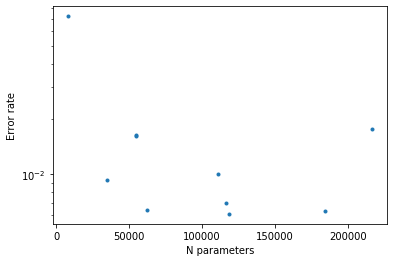

In [191]:
p = [7850, 216650, 54410, 54410, 110986, 116106, 34826, 62346, 118346, 184586]
a = [0.9274, 0.9824, 0.9838, 0.9837, 0.9899, 0.9930, 0.9907, 0.9936, 0.9939, 0.9937]
plt.plot(p,1-np.array(a),'.');
plt.yscale('log')
plt.xlabel('N parameters')
plt.ylabel('Error rate')

# Transfer

[[ 1  3  5  7  2  0 13 15 17  4]
 [21  6 16 10  9 11 18 29 31 19]
 [34  8 25 12 20 35 32 38 41 22]
 [37 14 28 27 26 47 36 42 46 33]
 [51 23 76 30 53 65 39 52 55 43]]


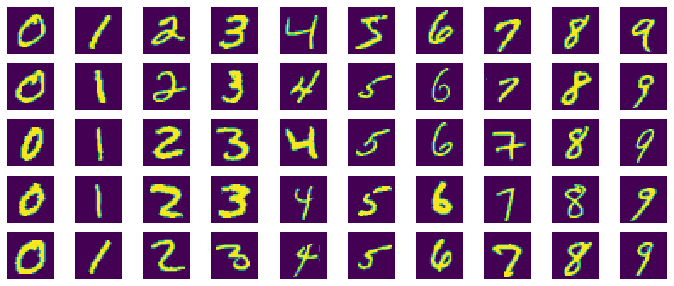

In [51]:
# Pick a few complete sets of digits

nrows = 5
hist = [0]*10
indices = np.zeros((nrows, 10), dtype=int)
plt.figure(figsize=(12,5))
i = 0
while min(hist) < nrows:
    label = np.argmax(ytrain[i])
    if hist[label]<nrows:
        plt.subplot(nrows, 10, 1+label+hist[label]*10)
        plt.imshow(xtrain[i,:,:,0]);
        #plt.title(label)
        plt.axis('off')
        indices[hist[label], label] = i
        hist[label] += 1
    i += 1
    
print(indices)


 3.942 3.911 3.838 3.724 3.632 3.537 3.447 3.307 3.052 3.016
 2.821 2.715 2.595 2.397 2.049 1.924 2.240 2.179 1.904 1.658
 1.618 1.513 1.530 1.478 1.431 1.438 1.367 1.399 1.360 1.357
 1.344 1.321 1.330 1.296 1.267 1.287 1.226 1.236 1.202 1.192
 1.188 1.206 1.164 1.161 1.142 1.155 1.120 1.107 1.100 1.091
Test loss: 2.371308289337158
Accuracy: 0.5902
Percent error: 40.98%


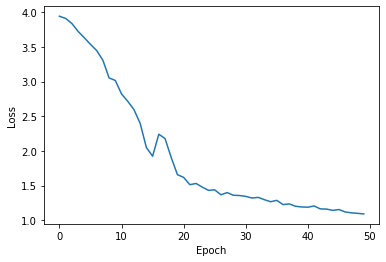

In [54]:
# Reset the model, and train it on 10 samples only 

model = build_model()

hist = model.fit(xtrain[indices[0,:]], ytrain[indices[0,:]],
                  batch_size=128,
                  epochs=50,
                  verbose=0,
                  validation_data=(xtest, ytest),
                  callbacks=[PrintDot()])

plt.plot(hist.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
print()

score = model.evaluate(xtest, ytest, verbose=0)
print("Test loss:",score[0])
print('Accuracy:', score[1])
print('Percent error:', f'{(1-score[1])*100:0.2f}%')

# Freeze layers and retrain

Refs:
* https://keras.io/guides/transfer_learning/

In [107]:
# Save weights

model.save('weights_full')

INFO:tensorflow:Assets written to: weights_full\assets


In [64]:
model.layers

In [65]:
for i in range(7): # ALl but the last one:
    model.layers[i].trainable = False
    
print([l.trainable for l in model.layers])

[False, False, False, False, False, False, False, True]


In [66]:
score = model.evaluate(xtest, ytest, verbose=0)
print("Test loss:",score[0])
print('Accuracy:', score[1])
print('Percent error:', f'{(1-score[1])*100:0.2f}%')

Test loss: 0.16863801363706588
Accuracy: 0.9813
Percent error: 1.87%


In [95]:
# Reset the last (softmax) layer:
model2 = tf.keras.Sequential()
for layer in model.layers[:-1]:
    model2.add(layer)
model2.add(tf.keras.layers.Dense(C.nclasses, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adadelta(learning_rate=1),
             metrics=['accuracy'])

for l in model2.layers:
    print(l)
print([l.trainable for l in model2.layers])

[False, False, False, False, False, False, False, True]


In [97]:
# Untrained, so should perform at chance level
score = model2.evaluate(xtest, ytest, verbose=0)
print("Test loss:",score[0])
print('Accuracy:', score[1])
print('Percent error:', f'{(1-score[1])*100:0.2f}%')

Test loss: 2.5280421451568604
Accuracy: 0.0864
Percent error: 91.36%


In [103]:
# Retrain last layer on one set of numbers only

hist = model2.fit(xtrain[indices[0,:]], ytrain[indices[0,:]],
                  batch_size=10,
                  epochs=50,
                  verbose=0,
                  validation_data=(xtest, ytest),
                  callbacks=[PrintDot()])

print()
score = model2.evaluate(xtest, ytest, verbose=0)
print("Test loss:",score[0])
print('Accuracy:', score[1])
print('Percent error:', f'{(1-score[1])*100:0.2f}%')


 .843 .832 .883 .864 .866 .915 .884 .839 .854 .825
 .796 .884 .828 .848 .819 .827 .848 .798 .812 .800
 .740 .805 .795 .799 .807 .788 .774 .728 .835 .777
 .759 .706 .757 .697 .752 .710 .740 .730 .694 .708
 .801 .692 .765 .660 .715 .698 .735 .702 .722 .696
Test loss: 0.9450716703414918
Accuracy: 0.9565
Percent error: 4.35%
